In [1]:
import numpy as np # for arrays
%matplotlib notebook
import matplotlib as mpl # for graphics
import matplotlib.pyplot as plt
import nibabel as nib # for loading neuroimages
import lddmm # algorithm
import vis # visualization
import tensorflow as tf

Importing helper functions
importing vis


In [2]:
dtype = tf.float32
idtype = tf.int64

In [3]:
# for development
import imp
vis = imp.reload(vis)
lddmm = imp.reload(lddmm)

importing vis
Importing helper functions


In [4]:
# load some example data
# we will deform the atlas to match the target
atlas_image_fname = 'Adt27-55_02_Adt27-55_02_MNI.img'
target_image_fname = 'Adt27-55_03_Adt27-55_03_MNI.img'

In [5]:
# load them
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [6]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing
if '.img' == atlas_image_fname[-4:]:    
    nx = img[0].header['dim'][1:4]
    dx = img[0].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
x = [np.arange(nxi)*dxi for nxi,dxi in zip(nx,dx)]


In [7]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]
# in this example, images are the same size
# this can be enfored after affine registration
# In the future, we can implement different sizes

In [8]:
f = plt.figure()
vis.imshow_slices(I,x=x,fig=f)
f.suptitle('Atlas I')


<IPython.core.display.Javascript object>

Text(0.5,0.98,'Atlas I')

In [9]:
f = plt.figure()
vis.imshow_slices(J,x=x,fig=f)
f.suptitle('Target J')

<IPython.core.display.Javascript object>

Text(0.5,0.98,'Target J')

<IPython.core.display.Javascript object>


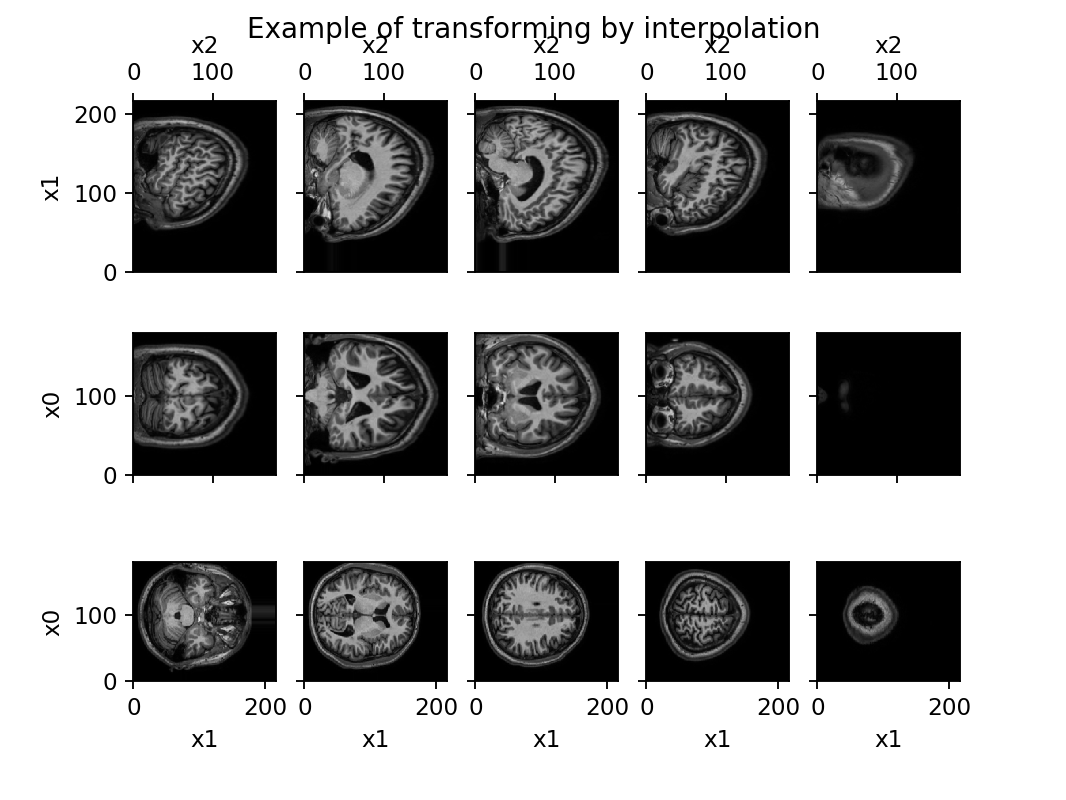

In [21]:
do_interp_test = True
if do_interp_test:
    # a quick test
    X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
    X0tf = tf.constant(X0,dtype=dtype)
    X1tf = tf.constant(X1,dtype=dtype)
    X2tf = tf.constant(X2,dtype=dtype)
    Itf = tf.constant(I,dtype=dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Id = lddmm.interp3(x[0],x[1],x[2],Itf,X0tf+10,X1tf*1.2,(X2tf/x[2][-1])**0.75*x[2][-1])
        Idnp = Id.eval()
    f = plt.figure()
    vis.imshow_slices(Idnp,x=x,fig=f)
    f.suptitle('Example of transforming by interpolation')
    

<IPython.core.display.Javascript object>


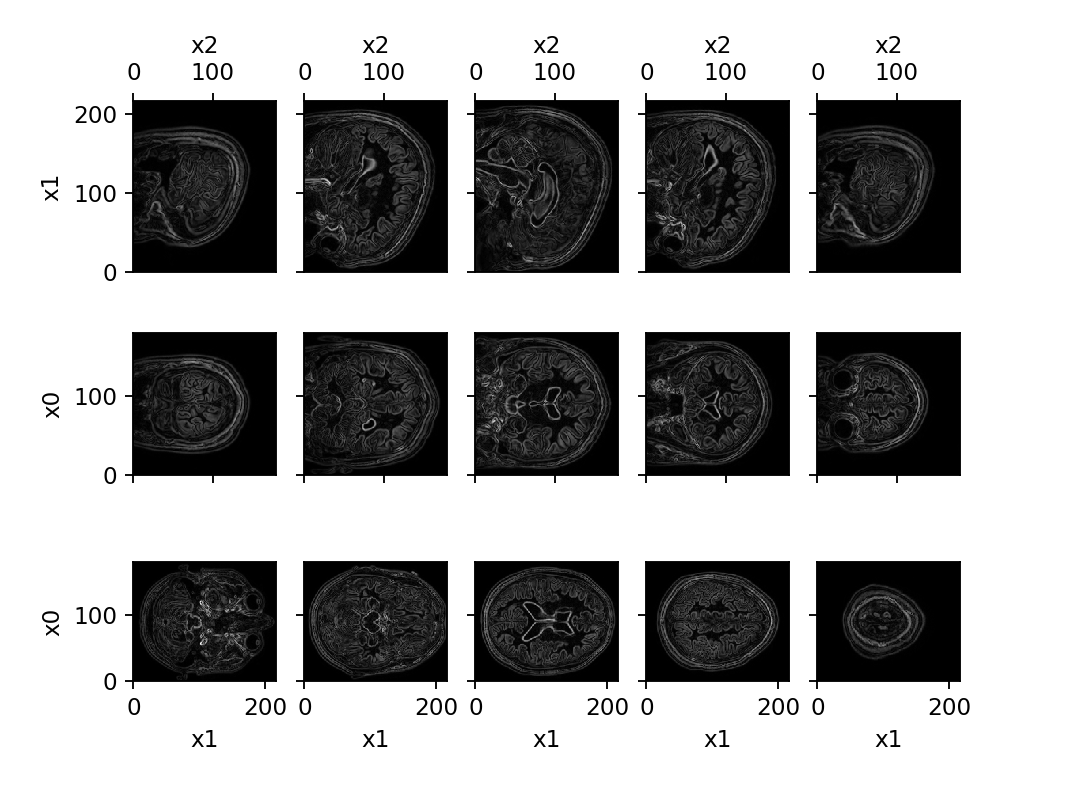

In [12]:
do_grad_test = True
if do_grad_test:
    # a quick test    
    Itf = tf.constant(I,dtype=dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        I_0,I_1,I_2 = lddmm.grad3(Itf,dx)
        Ishow = tf.sqrt(I_0**2 + I_1**2 + I_2**2)
        Ishownp = Ishow.eval()
    f = plt.figure()        
    vis.imshow_slices(Ishownp,x=x,fig=f)
    